## Analysis of the labels from Google Cloud

In [93]:
from google.cloud import firestore
from google.cloud import storage
from tqdm import tqdm
from pathlib import Path
import json 
from geopy import distance
from collections import Counter
import geopandas
import pandas as pd
import numpy as np
import contextily as cx
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#### Initialize Connection to gcloud

In [19]:
# Initialize connections to cloud storage and database
client = storage.Client()
db = firestore.Client()
gcloud_labeling_bucket = 'street2sat-gcloud-labeling'
coll = db.collection("street2sat")

#### Obtain all jsonl files

In [11]:
jsonl_blobs = [file for file in client.list_blobs(gcloud_labeling_bucket) if file.name.endswith(".jsonl")]

print(f"Found {len(jsonl_blobs)} jsonl files in the bucket.")

Found 2 jsonl files in the bucket.


#### Loads labels into list of dictionaries 

In [12]:
# gets image data from firestore and returns the coordinates 
def get_location_from_image_path(path: str):
    query = coll.where("input_img", "==", path).limit(1).get()
    return query[0].to_dict()['coord']

# opens all the blobs, if image has labels, adds those labels to a list
def load_labels(blobs: list):
    labels = []
    for blob in blobs:
        str_rep = blob.download_as_string()
        for image_labels in tqdm(str_rep.splitlines()):
            info_image = json.loads(image_labels)
            image_path = info_image['imageGcsUri']
            info_dict = {'imageGcsUri': image_path, 'coord': get_location_from_image_path(image_path)}
            for bounding_box in info_image['boundingBoxAnnotations']:
                bounding_box_info = {**info_dict, **bounding_box}
                labels.append(bounding_box_info)
    return labels 

labels = load_labels(jsonl_blobs)
print(f'Found {len(labels)} labels total in the files.')

100%|██████████| 999/999 [00:50<00:00, 19.81it/s]

Found 240 labels total in the files.


#### Helper Functions to filter labels

In [13]:
# Filters the labels based on which ones fall within the radius specified 
def location_query(coord: tuple, radius_km: float):
    valid_labels = [lab for lab in labels if distance.distance(coord, lab['coord']).km <= radius_km]
    return valid_labels

# Returns the counts of the list of labels that is passed 
def counts_of_labels(subset_of_labels: list):
    list_for_counter = [lab['displayName'] for lab in subset_of_labels]
    counts = Counter(list_for_counter)
    return dict(counts)

# Plots the labels on a map
def make_map(subset_of_labels: list):
    df = pd.DataFrame(subset_of_labels)
    df['long'] = df.apply(lambda row: row.coord[0], axis = 1)
    df['lat'] = df.apply(lambda row: row.coord[1], axis = 1)
    gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lat, df.long, crs='EPSG:4326'))
    
    ax = gdf.to_crs('EPSG:3857').plot(
        figsize=(10, 30), 
        marker='o', 
        column='displayName', 
        categorical=True,
        markersize=15,
        cmap = 'tab10',
        legend=True
    )
    ax.set_title("Label Locations")
    return cx.add_basemap(ax, source = cx.providers.OpenStreetMap.Mapnik)


In [14]:
counts_of_labels(labels)

{'maize': 191, 'sugarcane': 4, 'banana': 31, 'cassava': 7, 'millet': 7}

In [15]:
example1 = location_query(labels[90]['coord'], 200)
counts_of_labels(example1)


{'sugarcane': 4, 'banana': 23, 'cassava': 3, 'maize': 96}

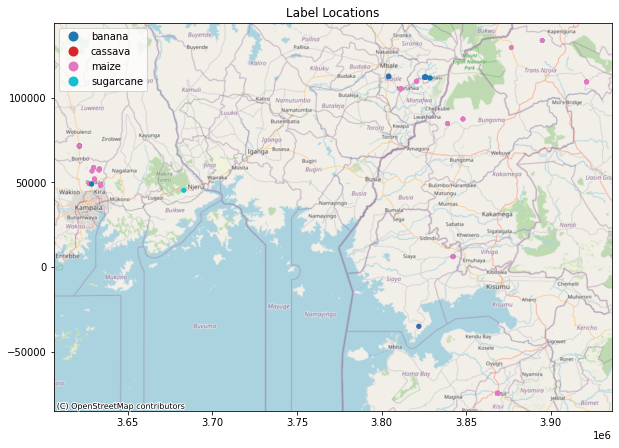

In [99]:
make_map(example1)

## Creating Training and Validation Split 

Three options: 
1. Crop Only Split
    - Take all the labels that we have and do a stratified split with each crop. Combine into one large dataset. 
2. Geographic Only Split
    - For each region, randomly split crops into train and valiation. Combine into one large dataset.  
3. Geographic And Crop Split
    - For each region, do a stratified split with each crop. Combine into one large dataset. 


#### Crop Only Split

In [100]:
df = pd.DataFrame(labels)
df[['long', 'lat']] = pd.DataFrame(df['coord'].tolist(), index=df.index)
df = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(df['imageGcsUri'], df['displayName'], test_size = .15, random_state = 2, stratify = df['displayName'])


In [101]:
print("TRAIN SPLIT")
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

print("VALIDATION")
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

TRAIN SPLIT
[['banana' 25]
 ['cassava' 6]
 ['maize' 135]
 ['millet' 6]
 ['sugarcane' 3]]
VALIDATION
[['banana' 4]
 ['cassava' 1]
 ['maize' 25]
 ['millet' 1]
 ['sugarcane' 1]]


#### Geographic Split Only

In [107]:
X = df.loc[:, ['imageGcsUri', 'lat', 'long', 'displayName']]
X.head()

,imageGcsUri,lat,long,displayName
0,gs://street2sat-uploaded/Uganda/2021-06-25_Edr...,30.140183,0.211058,maize
1,gs://street2sat-uploaded/Uganda/2021-06-25_Edr...,30.140183,0.211058,maize
2,gs://street2sat-uploaded/Uganda/2021-06-25_Edr...,30.140183,0.211058,maize
3,gs://street2sat-uploaded/Uganda/2021-06-25_Edr...,30.140183,0.211058,maize
4,gs://street2sat-uploaded/Uganda/2021-06-25_Edr...,30.140183,0.211058,maize


[[  0 189]
 [  1  18]]


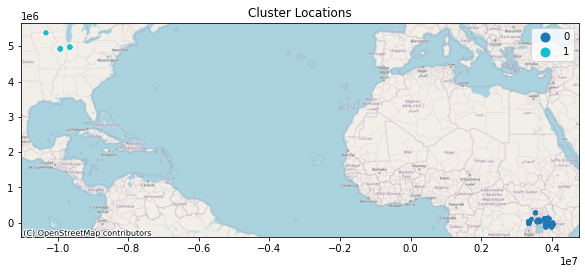

In [108]:
num_clusters = 2


kmeans = KMeans(n_clusters = num_clusters, init ='k-means++')
kmeans.fit(X[X.columns[1:3]])
X['label'] = kmeans.fit_predict(X[X.columns[1:3]])

centers = kmeans.cluster_centers_
labels_kmeans = kmeans.predict(X[X.columns[1:3]])

gdf = geopandas.GeoDataFrame(X, geometry=geopandas.points_from_xy(X.lat, X.long, crs='EPSG:4326'))
    
ax = gdf.to_crs('EPSG:3857').plot(
    figsize=(10, 30), 
    marker='o', 
    column='label', 
    categorical=True,
    markersize=15,
    cmap = 'tab10',
    legend=True
)
ax.set_title("Cluster Locations")
cx.add_basemap(ax, source = cx.providers.OpenStreetMap.Mapnik)

(unique, counts) = np.unique(labels_kmeans, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

In [112]:
all_x_train = []
all_x_test = []
all_y_train = []
all_y_test = []

for lab in X['label'].unique():
    df_label = X[X['label'] == lab]
    X_train, X_test, y_train, y_test = train_test_split(df_label['imageGcsUri'], df_label['displayName'], test_size = .15, random_state = 2)
    all_x_train.extend(X_train)
    all_x_test.extend(X_test)
    all_y_train.extend(y_train)
    all_y_test.extend(y_test)


print("TRAIN SPLIT")
(unique, counts) = np.unique(all_y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

print("VALIDATION")
(unique, counts) = np.unique(all_y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

TRAIN SPLIT
[['banana' '23']
 ['cassava' '6']
 ['maize' '138']
 ['millet' '6']
 ['sugarcane' '2']]
VALIDATION
[['banana' '6']
 ['cassava' '1']
 ['maize' '22']
 ['millet' '1']
 ['sugarcane' '2']]


#### Geographic And Crop Split

In [113]:
all_x_train = []
all_x_test = []
all_y_train = []
all_y_test = []

for lab in X['label'].unique():
    df_label = X[X['label'] == lab]
    X_train, X_test, y_train, y_test = train_test_split(df_label['imageGcsUri'], df_label['displayName'], test_size = .15, random_state = 2, stratify = df_label['displayName'])
    all_x_train.extend(X_train)
    all_x_test.extend(X_test)
    all_y_train.extend(y_train)
    all_y_test.extend(y_test)


print("TRAIN SPLIT")
(unique, counts) = np.unique(all_y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

print("VALIDATION")
(unique, counts) = np.unique(all_y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

TRAIN SPLIT
[['banana' '25']
 ['cassava' '6']
 ['maize' '135']
 ['millet' '6']
 ['sugarcane' '3']]
VALIDATION
[['banana' '4']
 ['cassava' '1']
 ['maize' '25']
 ['millet' '1']
 ['sugarcane' '1']]
